# Federated Learning Implementation with tensorflow



In [3]:
# """
# Adult Dataset Salary Prediction 
# This is part of a study to investigate Differetinal privacy in Machine learning, Naturally we wish to compare it with federated learning.



# Refrences:

# [1] Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018
# [2] Communication-Efficient Learning of Deep Networks from Decentralized Data, H. Brendan McMahan et al, arXiv:1602.05629v3 [cs.LG] 28 Feb 2017

# """

In [4]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix,f1_score
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History

import pandas as pd



C:\Users\riash\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [5]:
### Train/Test Data seperation

file_out = pd.read_csv('Data/adult_processed.csv')
cols = []
for i in list(file_out.columns):
    if  i != 'income':
        cols.append(i)

feature_set1 = pd.read_csv('Data/train.csv')
feature_set2 = pd.read_csv('Data/test.csv')

print(feature_set1['race_White'])
x = feature_set1[cols].copy().values
y = feature_set1[['income']].copy().values
        
sc = StandardScaler()
X_train = sc.fit_transform(x)
y_train = y

x2 = feature_set2[cols].copy().values
y2 = feature_set2[['income']].copy().values
        
X_test = sc.transform(x2)
y_test = y2


X_test.shape, y_test.shape 

0        1
1        1
2        1
3        1
4        1
        ..
39068    0
39069    1
39070    1
39071    1
39072    1
Name: race_White, Length: 39073, dtype: int64


((9768, 94), (9768, 1))

In [6]:
# Train/Test data based on  gender: 4 sets

# train

female_features =  feature_set1[feature_set1['gender_Female']==1]
x_female = female_features[cols].copy().values
y_female = female_features[['income']].copy().values

X_train_female = sc.fit_transform(x_female)
y_train_female = y_female

male_features = feature_set1[feature_set1['gender_Male']==1] 
x_male = male_features[cols].copy().values
y_male = male_features[['income']].copy().values

X_train_male = sc.fit_transform(x_male)
y_train_male = y_male

# test

female_features2 =  feature_set2[feature_set2['gender_Female']==1]
x_female2 = female_features2[cols].copy().values
y_female2 = female_features2[['income']].copy().values

X_test_female = sc.fit_transform(x_female2)
y_test_female = y_female2 

male_features2 = feature_set2[feature_set2['gender_Male']==1] 
x_male2 = male_features2[cols].copy().values
y_male2 = male_features2[['income']].copy().values

X_test_male = sc.fit_transform(x_male2)
y_test_male = y_male2


# checks
X_train.shape, X_train_female.shape, X_train_male.shape
# X_test.shape, X_test_female.shape, X_test_male.shape
# y_train.shape, y_train_female.shape, y_train_male.shape


((39073, 94), (12919, 94), (26154, 94))

In [7]:
# female_features_above30 = female_features[female_features['age']>30]
# x_female_age = female_features_above30[cols].copy().values
# y_female_age = female_features_above30[['income']].copy().values

# X_train_female_age = sc.fit_transform(x_female_age)
# y_train_female_age = y_female_age

# male_features_above30 = male_features[male_features['age']>30]
# x_male_age = male_features_above30[cols].copy().values
# y_male_age = male_features_above30[['income']].copy().values

# X_train_male_age = sc.fit_transform(x_male_age)
# y_train_male_age = y_male_age

# # test

# female_features_above30_2 =  female_features2[female_features2['age']>30]
# x_female_age2 = female_features_above30_2[cols].copy().values
# y_female_age2 = female_features_above30_2[['income']].copy().values

# X_test_female_age = sc.fit_transform(x_female_age2)
# y_test_female_age = y_female_age2 

# male_features_above30_2 = male_features2[male_features2['age']>30]
# x_male_age2 = male_features_above30_2[cols].copy().values
# y_male_age2 = male_features_above30_2[['income']].copy().values

# X_test_male_age = sc.fit_transform(x_male_age2)
# y_test_male_age = y_male_age2


# # checks
# X_train.shape, X_train_female_age.shape, X_train_male_age.shape
# X_test.shape, X_test_female.shape, X_test_male.shape
# y_train.shape, y_train_female.shape, y_train_male.shape

In [9]:

# def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    
#     ''' return: a dictionary with keys clients' names and value as 
#                 data shards - tuple of images and label lists.
#         args: 
#             image_list: a list of numpy arrays of training images
#             label_list:a list of binarized labels for each image
#             num_client: number of fedrated members (clients)
#             initials: the clients'name prefix, e.g, clients_1 
            
#     '''

#     #create a list of client names
# #     client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

# #     iid
# #     #randomize the data
# #     data = list(zip(image_list, label_list))
# #     random.shuffle(data)
    
   
    
# #     non-iid //////////////////////////////////////
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

# # LOGIC:
# #    image_list length-->total data items
# #    taking 50 images in each shard--> num_shards = image_list/41 gives 953 shards
# #    num_shard = num_shards + 1 if(image_list%50 >0) 

#     num_shards, num_imgs = 953, 41
#     idx_shard = [i for i in range(num_shards)]
#     dict_users = {i: np.array([]) for i in range(num_clients)}
# #     dict_users = [i for i in range(num_clients)]
# #     idxs = np.arange(num_shards*num_imgs)
# #     labels = dataset.train_labels.numpy()

#     max_y = np.argmax(label_list, axis=-1)
# #     image_list = np.argmax(image_list, axis=-1)
# #     print(idxs.shape, label_list.shape)
    
# #     idxs_labels = np.vstack((idxs, max_y))
# #     idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
# #     idxs = idxs_labels[0, :]


# #   ////////////////////////////////////////////////////  
#     #shard data and place at each client
# #     size = len(data)//num_clients
# #     shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

# #     #number of clients must equal number of shards
# #     assert(len(shards) == len(client_names))

# #     print(len(image_list))
# #     for i in range(len(client_names)):
# #         print(client_names[i], len(shards[i]))
              
# #     return {client_names[i] : shards[i] for i in range(len(client_names))} 


# clients = create_clients(X_train, y_train, num_clients=15, initial='client')
# # print(clients)

# for i in range(len(clients.keys())):
#         print(i, len(clients[i]))

# print(type(clients))

In [10]:
# gender split

dict_users = {i: np.array([]) for i in range(4)}
data_out = []

def create_hetero_clients( image_list, label_list, start_client = 0, num_clients=10, initial='clients'):
    
    selected_inds = []

    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]
    
    data_out = data
    
    num_shards, num_imgs = int(len(image_list)/30), 30
    idx_shard = [i for i in range(num_shards)]

    min_shard = 1
    max_shard = 60  #953/15 = 63.53
    
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=(num_clients-start_client))
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)


    if sum(random_shard_size) > num_shards:
        
        for i in range(start_client, num_clients):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(start_client, num_clients):
            if len(idx_shard) == 0:
                continue
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

    else:

        for i in range(start_client, num_clients):
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
#             shard_size = random_shard_size[int(i/len(random_shard_size)) - 1]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[k]) == 0):
                    dict_users[k] = data[ind1: ind2]
                else:
                    dict_users[k] = np.concatenate(
                    (dict_users[k],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])
                
                
    return dict_users, selected_inds, data_out



In [11]:
dict_users = {i: np.array([]) for i in range(4)}

def create_client_iid(image_list, label_list, client_num):    
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]
    
    dict_users[client_num] = data
    
    return dict_users

In [12]:
def get_hetero_clients():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    x_female = female_features[cols].copy().values
    y_female = female_features[['income']].copy().values

    X_train_female = sc.fit_transform(x_female)
    y_train_female = y_female

    male_features = feature_set1[feature_set1['gender_Male']==1] 
    x_male = male_features[cols].copy().values
    y_male = male_features[['income']].copy().values

    X_train_male = sc.fit_transform(x_male)
    y_train_male = y_male

    # test

    female_features2 =  feature_set2[feature_set2['gender_Female']==1]
    x_female2 = female_features2[cols].copy().values
    y_female2 = female_features2[['income']].copy().values

    X_test_female = sc.fit_transform(x_female2)
    y_test_female = y_female2 

    male_features2 = feature_set2[feature_set2['gender_Male']==1] 
    x_male2 = male_features2[cols].copy().values
    y_male2 = male_features2[['income']].copy().values

    X_test_male = sc.fit_transform(x_male2)
    y_test_male = y_male2

#     shuffling male and female datalists
#     print(X_train_male.shape)
    data = list(zip(X_train_male, y_train_male))
    random.shuffle(data)
    
    X_train_male, y_train_male = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(X_train_female, y_train_female))
    random.shuffle(data)
    
    X_train_female, y_train_female = list(zip(*data))[0], list(zip(*data))[1]
    
    
    
    # 1 all male
    clients, inds, data_out1 = create_hetero_clients(X_train_male[:5230], y_train_male[:5230], start_client = 0, num_clients=1, initial='client') 
    # 1 all female
    clients2, inds2, data_out2 = create_hetero_clients(X_train_female[:2584], y_train_female[:2584], start_client = 1, num_clients=2, initial='client')
    clients = {**clients, **clients2}

    used_x = []
    used_y = []
    used_data = []
  
    for i,j in list(inds):
        for x in range(i,j):
            used_data.insert(len(used_data)-1,(data_out1[x]))  
  
    for x in used_data:
        used_x.insert(len(used_x)-1,x[0])
        used_y.insert(len(used_y)-1,x[1])  
   
    used_data.clear()

    for i,j in list(inds2):
        for x in range(i,j):
            used_data.insert(len(used_data)-1,(data_out2[x]))  

    for x in used_data:
        used_x.insert(len(used_x)-1,x[0])
        used_y.insert(len(used_y)-1,x[1])  

    # 3 mix
    X_train_mix = np.setdiff1d(X_train, np.array(used_x))#53834, 64278
    y_train_mix = np.setdiff1d(y_train, np.array(used_y))

#     print(X_train_mix.shape, X_train.shape)
#     print(y_train_mix.shape, y_train.shape)

    clients3, inds3 , data_out= create_hetero_clients(X_train_mix, y_train_mix, start_client = 2, num_clients=5, initial='client')
    clients = {**clients, **clients3}
    
    return clients


In [13]:
def initializer():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    x_female = female_features[cols].copy().values
    y_female = female_features[['income']].copy().values

    X_train_female = sc.fit_transform(x_female)
    y_train_female = y_female

    male_features = feature_set1[feature_set1['gender_Male']==1] 
    x_male = male_features[cols].copy().values
    y_male = male_features[['income']].copy().values

    X_train_male = sc.fit_transform(x_male)
    y_train_male = y_male

    # test

    female_features2 =  feature_set2[feature_set2['gender_Female']==1]
    x_female2 = female_features2[cols].copy().values
    y_female2 = female_features2[['income']].copy().values

    X_test_female = sc.fit_transform(x_female2)
    y_test_female = y_female2 

    male_features2 = feature_set2[feature_set2['gender_Male']==1] 
    x_male2 = male_features2[cols].copy().values
    y_male2 = male_features2[['income']].copy().values

    X_test_male = sc.fit_transform(x_male2)
    y_test_male = y_male2
    
#   train-- with age
    female_features_above30 = female_features[female_features['age']>30]
    x_female_age = female_features_above30[cols].copy().values
    y_female_age = female_features_above30[['income']].copy().values

    X_train_female_age = sc.fit_transform(x_female_age)
    y_train_female_age = y_female_age

    male_features_above30 = male_features[male_features['age']>30]
    x_male_age = male_features_above30[cols].copy().values
    y_male_age = male_features_above30[['income']].copy().values

    X_train_male_age = sc.fit_transform(x_male_age)
    y_train_male_age = y_male_age

    # test

    female_features_above30_2 =  female_features2[female_features2['age']>30]
    x_female_age2 = female_features_above30_2[cols].copy().values
    y_female_age2 = female_features_above30_2[['income']].copy().values

    X_test_female_age = sc.fit_transform(x_female_age2)
    y_test_female_age = y_female_age2 

    male_features_above30_2 = male_features2[male_features2['age']>30]
    x_male_age2 = male_features_above30_2[cols].copy().values
    y_male_age2 = male_features_above30_2[['income']].copy().values

    X_test_male_age = sc.fit_transform(x_male_age2)
    y_test_male_age = y_male_age2
    
    return X_train_male_age, y_train_male_age,  X_train_female_age, y_train_female_age

In [14]:
def initializer_income():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    female_features_above30 = female_features[female_features['income']==1]
    x_female_age = female_features_above30[cols].copy().values
    y_female_age = female_features_above30[['income']].copy().values
    
    female_features_below = female_features[female_features['income']==0]
    x_female_less = female_features_below[cols].copy().values
    y_female_less = female_features_below[['income']].copy().values

    X_train_female_age = sc.fit_transform(x_female_age)
    y_train_female_age = y_female_age
    
    X_train_female_less = sc.fit_transform(x_female_less)
    y_train_female_less = y_female_less


    male_features = feature_set1[feature_set1['gender_Male']==1] 
    male_features_above30 = male_features[male_features['income']==1]
    x_male_age = male_features_above30[cols].copy().values
    y_male_age = male_features_above30[['income']].copy().values
    
    male_features_below = male_features[male_features['income']==0]
    x_male_less = male_features_below[cols].copy().values
    y_male_less = male_features_below[['income']].copy().values

    X_train_male_age = sc.fit_transform(x_male_age)
    y_train_male_age = y_male_age
    
    X_train_male_less = sc.fit_transform(x_male_less)
    y_train_male_less = y_male_less


    # test

    female_features2 =  feature_set2[feature_set2['gender_Female']==1]
    female_features_above30_2 =  female_features2[female_features2['income']==1]
    x_female_age2 = female_features_above30_2[cols].copy().values
    y_female_age2 = female_features_above30_2[['income']].copy().values

    X_test_female_age = sc.fit_transform(x_female_age2)
    y_test_female_age = y_female_age2 


    male_features2 = feature_set2[feature_set2['gender_Male']==1]
    male_features_above30_2 = male_features2[male_features2['income']==1]
    x_male_age2 = male_features_above30_2[cols].copy().values
    y_male_age2 = male_features_above30_2[['income']].copy().values

    X_test_male_age = sc.fit_transform(x_male_age2)
    y_test_male_age = y_male_age2

    
    return [X_train_male_age, y_train_male_age,  X_train_female_age, y_train_female_age, X_train_male_less, y_train_male_less,  X_train_female_less, y_train_female_less]

In [15]:
def get_hetero_clients_gender(train_sets):
    
    data = list(zip(train_sets[0], train_sets[1]))
    random.shuffle(data)
    
#     print(type(train_sets), type(train_sets[0]),type(list(list(zip(*data))[0]) ), type(data))
    
    train_sets[0] = list(list(zip(*data))[0])
    train_sets[1] = list(list(zip(*data))[1])
    data.clear()
    
    data = list(zip(train_sets[2], train_sets[3]))
    random.shuffle(data)
    
    train_sets[2], train_sets[3] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[4], train_sets[5]))
    random.shuffle(data)
    
    train_sets[4], train_sets[5] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[6], train_sets[7]))
    random.shuffle(data)
    
    train_sets[6], train_sets[7] = list(zip(*data))[0], list(zip(*data))[1]
    
#     NON_IID
#     clients, inds, data_out1 = create_hetero_clients(train_sets[0], train_sets[1], start_client = 0, num_clients=1, initial='client') 
    
#     clients2, inds2, data_out2 = create_hetero_clients(train_sets[2], train_sets[3], start_client = 1, num_clients=2, initial='client')
#     clients = {**clients, **clients2}
    
#     clients3, inds3, data_out3 = create_hetero_clients(train_sets[4], train_sets[5], start_client = 2, num_clients=3, initial='client')
#     clients = {**clients, **clients3}
    
#     clients4, inds4, data_out4 = create_hetero_clients(train_sets[6], train_sets[7], start_client = 3, num_clients=4, initial='client')
#     clients = {**clients, **clients4}

#     IID
    clients = create_client_iid(train_sets[0], train_sets[1], 0)
    
    clients2 = create_client_iid(train_sets[2], train_sets[3], 1)
    clients = {**clients, **clients2}
    
    clients3 = create_client_iid(train_sets[4], train_sets[5], 2)
    clients = {**clients, **clients3}
    
    clients4 = create_client_iid(train_sets[6], train_sets[7], 3)
    clients = {**clients, **clients4}
    
    
#     ________________________________________________________
#     used_x = []
#     used_y = []
#     used_data = []
  
#     for i,j in list(inds):
#         for x in range(i,j):
#             used_data.insert(len(used_data)-1,(data_out1[x]))  
  
#     for x in used_data:
#         used_x.insert(len(used_x)-1,x[0])
#         used_y.insert(len(used_y)-1,x[1])  
   
#     used_data.clear()

#     for i,j in list(inds2):
#         for x in range(i,j):
#             used_data.insert(len(used_data)-1,(data_out2[x]))  

#     for x in used_data:
#         used_x.insert(len(used_x)-1,x[0])
#         used_y.insert(len(used_y)-1,x[1])  

#     # 3 mix
#     X_train_mix = np.setdiff1d(X_train, np.array(used_x))#53834, 64278
#     y_train_mix = np.setdiff1d(y_train, np.array(used_y))

#     print(X_train_mix.shape, X_train.shape)
#     print(type(X_train_mix), type(X_train))
#     print(type(data_out))
#     print(y_train_mix.shape, y_train.shape)

#     clients3, inds3 , data_out= create_hetero_clients(X_train, y_train, start_client = 2, num_clients=5, initial='client')
#     clients = {**clients, **clients3}
    
    return clients


In [16]:
def initializer_income_race_gender():
    
    female_features =  feature_set1[feature_set1['gender_Female']==1]
    female_features_above50 = female_features[female_features['income']==1]
    female_features_above50_white = female_features_above50[female_features_above50['race_White']==1]
    female_features_above50_black = female_features_above50[female_features_above50['race_Black']==1]
    
#     white, female, >50k
    x_female_white_more = female_features_above50_white[cols].copy().values
    y_female_white_more = female_features_above50_white[['income']].copy().values
    X_train_female_white_more = sc.fit_transform(x_female_white_more)
    y_train_female_white_more = y_female_white_more
    
#     black, female, >50k
    x_female_black_more = female_features_above50_black[cols].copy().values
    y_female_black_more = female_features_above50_black[['income']].copy().values
    X_train_female_black_more = sc.fit_transform(x_female_black_more)
    y_train_female_black_more = y_female_black_more
    
    female_features_below = female_features[female_features['income']==0]
    female_features_below_white = female_features_below[female_features_below['race_White']==1]
    female_features_below_black = female_features_below[female_features_below['race_Black']==1]
    
#    white, female, <=50k
    x_female_white_less = female_features_below_white[cols].copy().values
    y_female_white_less = female_features_below_white[['income']].copy().values
    X_train_female_white_less = sc.fit_transform(x_female_white_less)
    y_train_female_white_less = y_female_white_less
    
#    black, female, <=50k
    x_female_black_less = female_features_below_black[cols].copy().values
    y_female_black_less = female_features_below_black[['income']].copy().values
    X_train_female_black_less = sc.fit_transform(x_female_black_less)
    y_train_female_black_less = y_female_black_less
    


    male_features = feature_set1[feature_set1['gender_Male']==1] 
    male_features_above50 = male_features[male_features['income']==1]
    male_features_above50_white = male_features_above50[male_features_above50['race_White']==1]
    male_features_above50_black = male_features_above50[male_features_above50['race_Black']==1]
    
#     white, male, >50k
    x_male_white_more = male_features_above50_white[cols].copy().values
    y_male_white_more = male_features_above50_white[['income']].copy().values
    X_train_male_white_more = sc.fit_transform(x_male_white_more)
    y_train_male_white_more = y_male_white_more
    
#     black, male, >50k
    x_male_black_more = male_features_above50_black[cols].copy().values
    y_male_black_more = male_features_above50_black[['income']].copy().values
    X_train_male_black_more = sc.fit_transform(x_male_black_more)
    y_train_male_black_more = y_male_black_more
    
    male_features_below = male_features[male_features['income']==0]
    male_features_below_white = male_features_below[male_features_below['race_White']==1]
    male_features_below_black = male_features_below[male_features_below['race_Black']==1]
    
#    white, male, <=50k
    x_male_white_less = male_features_below_white[cols].copy().values
    y_male_white_less = male_features_below_white[['income']].copy().values
    X_train_male_white_less = sc.fit_transform(x_male_white_less)
    y_train_male_white_less = y_male_white_less
    
#    black, male, <=50k
    x_male_black_less = male_features_below_black[cols].copy().values
    y_male_black_less = male_features_below_black[['income']].copy().values
    X_train_male_black_less = sc.fit_transform(x_male_black_less)
    y_train_male_black_less = y_male_black_less
    
#     print("fwm: ", X_train_female_white_more.shape, y_train_female_white_more.shape,
#           "fbm: ", X_train_female_black_more.shape, y_train_female_black_more.shape, 
#             "fwl: ", X_train_female_white_less.shape, y_train_female_white_less.shape, 
#             "fbl: ", X_train_female_black_less.shape,  y_train_female_black_less.shape,
#             "mwm: ", X_train_male_white_more.shape, y_train_male_white_more.shape,
#             "mbm: ", X_train_male_black_more.shape, y_train_male_black_more.shape,
#             "mwl: ", X_train_male_white_less.shape, y_train_male_white_less.shape,
#             "mbl: ", X_train_male_black_less.shape, y_train_male_black_less.shape)

    
    return [X_train_female_white_more, y_train_female_white_more, 
            X_train_female_black_more, y_train_female_black_more, 
            X_train_female_white_less, y_train_female_white_less, 
            X_train_female_black_less, y_train_female_black_less,
            X_train_male_white_more, y_train_male_white_more,
            X_train_male_black_more, y_train_male_black_more,
            X_train_male_white_less, y_train_male_white_less,
            X_train_male_black_less, y_train_male_black_less]

In [17]:
# initializer_income_race_gender()

[array([[ 1.63527959,  1.82817485, -0.71117516, ...,  0.24181517,
          0.        ,  0.        ],
        [-0.96356361, -1.04308228,  0.18764645, ...,  0.24181517,
          0.        ,  0.        ],
        [-0.30410003,  1.82817485,  0.07554836, ...,  0.24181517,
          0.        ,  0.        ],
        ...,
        [ 0.28929067,  0.62409928, -0.01914642, ...,  0.24181517,
          0.        ,  0.        ],
        [ 1.33253927,  2.01341724,  1.56784985, ...,  0.24181517,
          0.        ,  0.        ],
        [-0.21293351,  2.47652323, -0.20536085, ...,  0.24181517,
          0.        ,  0.        ]]),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[-0.51750424,  0.48583798, -0.07896002, ...,  0.25131234,
          0.        ,  0.        ],
        [-0.95890653,  0.59838302, -0.43961139, ...,  0.25131234,
          0.        ,  0.        ],
        [ 1.43146628,  1.72383338, -1.26538864, ...,  0.2513123

In [18]:
def get_hetero_clients_gender_race(train_sets):
    data = list(zip(train_sets[0], train_sets[1]))
    random.shuffle(data)
    
#     print(type(train_sets), type(train_sets[0]),type(list(list(zip(*data))[0]) ), type(data))
    
    train_sets[0] = list(list(zip(*data))[0])
    train_sets[1] = list(list(zip(*data))[1])
    data.clear()
    
    data = list(zip(train_sets[2], train_sets[3]))
    random.shuffle(data)
    
    train_sets[2], train_sets[3] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    data = list(zip(train_sets[4], train_sets[5]))
    random.shuffle(data)
    
    train_sets[4], train_sets[5] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[6], train_sets[7]))
    random.shuffle(data)
    
    train_sets[6], train_sets[7] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[8], train_sets[9]))
    random.shuffle(data)
    
    train_sets[8], train_sets[9] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[10], train_sets[11]))
    random.shuffle(data)
    
    train_sets[10], train_sets[11] = list(zip(*data))[0], list(zip(*data))[1]
    
    data = list(zip(train_sets[12], train_sets[13]))
    random.shuffle(data)
    
    train_sets[14], train_sets[15] = list(zip(*data))[0], list(zip(*data))[1]
    data.clear()
    
    data = list(zip(train_sets[14], train_sets[15]))
    random.shuffle(data)
    
    train_sets[14], train_sets[15] = list(zip(*data))[0], list(zip(*data))[1]
    
#     for i in range(7):

#         data = list(zip(train_sets[i], train_sets[i+1]))
#         random.shuffle(data)

# #         print(type(train_sets), type(train_sets[0]),type(list(list(zip(*data))[0]) ), type(data))

#         train_sets[i], train_sets[i+1] = list(zip(*data))[0], list(zip(*data))[1]
#         data.clear()
    
    # 1 all male
    clients, inds, data_out1 = create_hetero_clients(train_sets[0], train_sets[1], start_client = 0, num_clients=1, initial='client') 
    # 1 all female
    clients2, inds2, data_out2 = create_hetero_clients(train_sets[2], train_sets[3], start_client = 1, num_clients=2, initial='client')
    clients = {**clients, **clients2}
    
    clients3, inds3, data_out3 = create_hetero_clients(train_sets[4], train_sets[5], start_client = 2, num_clients=3, initial='client')
    clients = {**clients, **clients3}
    
    clients4, inds4, data_out4 = create_hetero_clients(train_sets[6], train_sets[7], start_client = 3, num_clients=4, initial='client')
    clients = {**clients, **clients4}
    
    clients5, inds5, data_out5 = create_hetero_clients(train_sets[2], train_sets[3], start_client = 4, num_clients=5, initial='client')
    clients = {**clients, **clients5}
    
    clients6, inds6, data_out6 = create_hetero_clients(train_sets[4], train_sets[5], start_client = 5, num_clients=6, initial='client')
    clients = {**clients, **clients6}
    
    clients7, inds7, data_out7 = create_hetero_clients(train_sets[6], train_sets[7], start_client = 6, num_clients=7, initial='client')
    clients = {**clients, **clients7}
    
    clients8, inds8, data_out8 = create_hetero_clients(train_sets[6], train_sets[7], start_client = 7, num_clients= 8, initial='client')
    clients = {**clients, **clients8}
    
    return clients


In [57]:
# take bs = 128 for 5 clients and 10 rounds
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    data = []
    label = []
    for x in data_shard:
        data.append(x[0])
        label.append(x[1])
    #seperate shard into data and labels lists
#     data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
#     print( label[0])
    return dataset.shuffle(len(label)).batch(bs)

In [62]:

#process and batch the training data for each client
def batch_clients(clients):
    clients_batched = dict()
    for (client_name, data) in clients.items():
#         print("data ",len(data))
#         clients_batched[client_name] = batch_data(data)#non-IID
        clients_batched[client_name] = batch_data(data,1) #IID
    

    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
    
#     test_batched
    return clients_batched, test_batched


In [61]:
clients = get_hetero_clients_gender(list(train_sets) )
# print("client0: ", clients[0])

clients_batched, test_batched = batch_clients(clients)
print("client batched 0: ", len(clients_batched[0]))
print("test" ,X_test.shape)
train_list = initializer_income()
for i in train_list:
    print(i.shape)
    
client_names= list(clients_batched.keys())

for client in client_names:
    print(client," ", len(clients_batched[client]))

client batched 0:  7895
test (9768, 94)
(7895, 94)
(7895, 1)
(1435, 94)
(1435, 1)
(18259, 94)
(18259, 1)
(11484, 94)
(11484, 1)
0   7895
1   1435
2   18259
3   11484


In [21]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes=2 , learning_rate = 0.001, metric = "accuracy"):

        model = Sequential()
        
        model.add(Dense(128, input_shape = (shape,)))
#         model.add(Dense(128, Activation("relu")))
#         model.add(Dense(64, Activation("relu")))
#         model.add(Dense(32, Activation("relu")))
#         model.add(Dense(1))
        
        model.add(Dense(128, Activation("tanh")))
        model.add(Dense(64, Activation("tanh")))
        model.add(Dense(32, Activation("tanh")))
        model.add(Dense(1,Activation('sigmoid')))
        


        return model

In [22]:
lr = 0.005
comms_round = 10
loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']

optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )     



In [23]:


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
#     print(len(scaled_weight_list))
    for grad_list_tuple in zip(*scaled_weight_list):
#         print(len(grad_list_tuple))
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    
#     cce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    logits = model.predict(X_test)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    acc = score[1] ; loss = score[0]
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))

    return acc, loss

In [64]:

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X_train.shape[1] ,classes=2)
global_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
# clients_batched, test_batched = batch_clients(clients)
# client_names= list(clients_batched.keys())
# client_names = [0, 1, 2, 3,4, 5, 6, 7, 8]
client_names = [0, 1, 2, 3]
# print(client_names, "asugdefbh")
# print(clients_batched)
global_loss_list = []
global_freq_list = []
global_acc_list = []
client_loss = {i: np.array([]) for i in range(len(client_names))}
client_accuracy = {i: np.array([]) for i in range(len(client_names))}
client_frequency = {i: np.array([]) for i in range(len(client_names))}

train_sets = initializer_income()
# train_sets = initializer_income_race_gender()

# print(len(train_sets))
#commence global training loop
for comm_round in range(comms_round):
    epoch_freq = 0
#     clients = create_clients(X_train, y_train, num_clients=15, initial='client')
#     clients = get_hetero_clients()
    clients = get_hetero_clients_gender(list(train_sets) )
#     clients = get_hetero_clients_gender_race(list(train_sets) )
#     print("client0: ", clients[0])

    clients_batched, test_batched = batch_clients(clients)
#     print("client batched 0: ", clients_batched[1])
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
#     print(client_names)
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X_train.shape[1],classes=2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        history = local_model.fit(clients_batched[client], epochs=1, verbose=1)
        
#         get client acc, loss
#         print(client)
        if(len(client_loss[client])== 0):
            client_loss[client] = [history.history['loss'][0]]
            client_accuracy[client] = [history.history['binary_accuracy'][0]]
            client_frequency[client] = [len(clients_batched[client])]
        
        else:
            client_loss[client] = np.append(client_loss[client], (history.history['loss'][0]))
            client_frequency[client] = np.append(client_frequency[client], len(clients_batched[client]))
            client_accuracy[client] = np.append(client_accuracy[client], (history.history['binary_accuracy'][0]))
        
        epoch_freq += len(clients_batched[client])
        
        print("client", client, "loss -->" ,client_loss[client], "freq->", client_frequency[client], "accuracy->", client_accuracy[client])
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    
    global_freq_list.append(epoch_freq)
    epoch_freq = 0
    

#     test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_loss_list.append(global_loss)
        global_acc_list.append(global_acc)
        
        print("global_loss_list: ", global_loss_list )
        print("global_acc_list: ", global_acc_list )
        print("global_freq_list: ", global_freq_list)



7895/7895 [==============================] - 6s 766us/step - loss: 0.0468 - binary_accuracy: 0.9937
client 0 loss --> [0.046759430319070816] freq-> [7895] accuracy-> [0.9936668872833252]
18259/18259 [==============================] - 15s 812us/step - loss: 0.0397 - binary_accuracy: 0.9961
client 2 loss --> [0.03972215577960014] freq-> [18259] accuracy-> [0.9961115121841431]
11484/11484 [==============================] - 12s 1ms/step - loss: 0.1072 - binary_accuracy: 0.9889
client 3 loss --> [0.10719390958547592] freq-> [11484] accuracy-> [0.9888540506362915]
1435/1435 [==============================] - 1s 942us/step - loss: 0.4473 - binary_accuracy: 0.8913
client 1 loss --> [0.4473094344139099] freq-> [1435] accuracy-> [0.8912891745567322]
comm_round: 0 | global_acc: 75.819% | global_loss: 0.7258363366127014
global_loss_list:  [0.7258363366127014]
global_acc_list:  [0.7581900358200073]
global_freq_list:  [39073]
7895/7895 [==============================] - 9s 1ms/step - loss: 0.2233 - 

1435/1435 [==============================] - 1s 948us/step - loss: 1.1164 - binary_accuracy: 0.4780
client 1 loss --> [0.44730943 1.00544584 1.24900603 1.09015918 1.2009567  1.20884359
 1.11642206] freq-> [1435 1435 1435 1435 1435 1435 1435] accuracy-> [0.89128917 0.49756098 0.37770036 0.50522649 0.44808361 0.43135887
 0.47804877]
7895/7895 [==============================] - 9s 1ms/step - loss: 0.3006 - binary_accuracy: 0.8808
client 0 loss --> [0.04675943 0.22334448 0.3253662  0.3327828  0.32753864 0.30964363
 0.30064547] freq-> [7895 7895 7895 7895 7895 7895 7895] accuracy-> [0.99366689 0.91247624 0.87321091 0.86865103 0.87473083 0.8781507
 0.88081062]
18259/18259 [==============================] - 18s 1ms/step - loss: 0.0240 - binary_accuracy: 0.9999
client 2 loss --> [0.03972216 0.02067855 0.01909248 0.02059607 0.02184644 0.02210405
 0.0240159 ] freq-> [18259 18259 18259 18259 18259 18259 18259] accuracy-> [0.99611151 0.99989045 1.         1.         1.         0.99994522
 0.999945

client_ 0  loss:  [0.04675943 0.22334448 0.3253662  0.3327828  0.32753864 0.30964363
 0.30064547 0.2881389  0.30844659 0.29107651] freq:  [7895 7895 7895 7895 7895 7895 7895 7895 7895 7895] acc [0.99366689 0.91247624 0.87321091 0.86865103 0.87473083 0.8781507
 0.88081062 0.88777709 0.87941736 0.88448387]


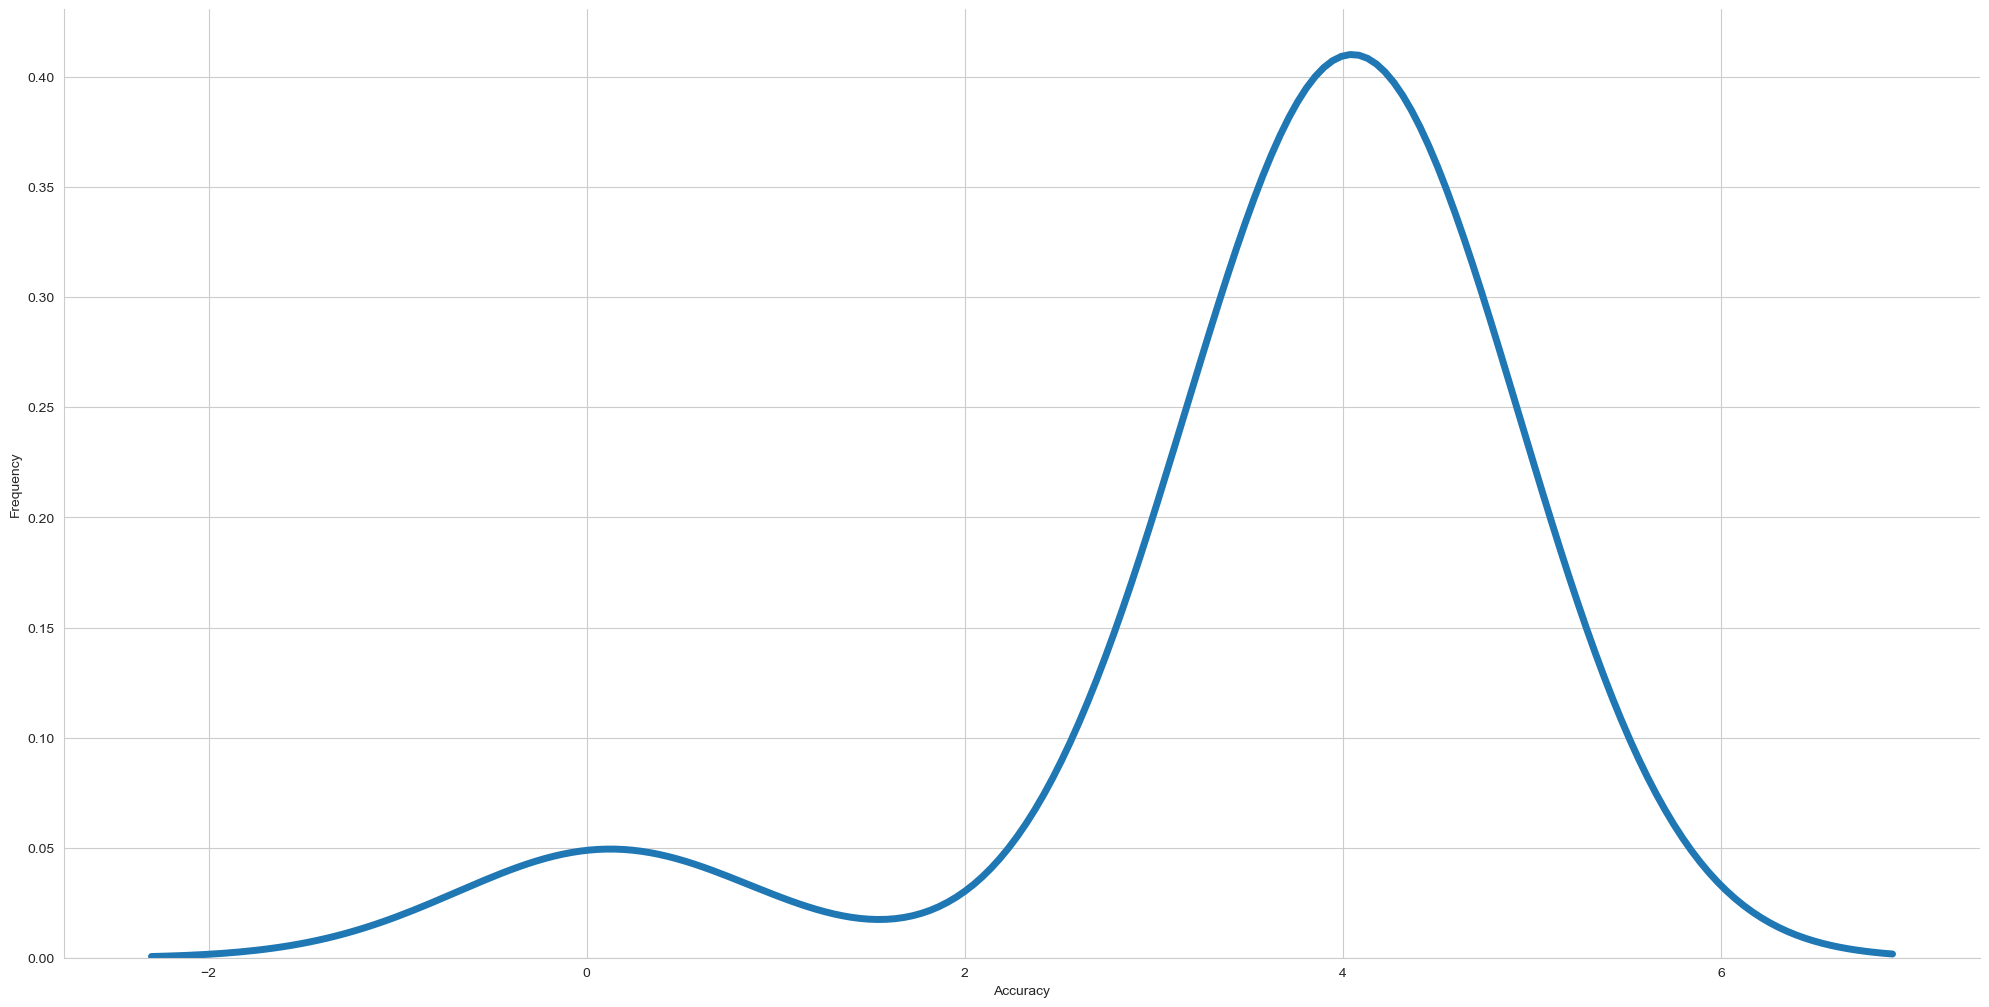

client_ 1  loss:  [0.44730943 1.00544584 1.24900603 1.09015918 1.2009567  1.20884359
 1.11642206 1.12442636 1.07541847 1.10691833] freq:  [1435 1435 1435 1435 1435 1435 1435 1435 1435 1435] acc [0.89128917 0.49756098 0.37770036 0.50522649 0.44808361 0.43135887
 0.47804877 0.47456446 0.50662023 0.48989546]


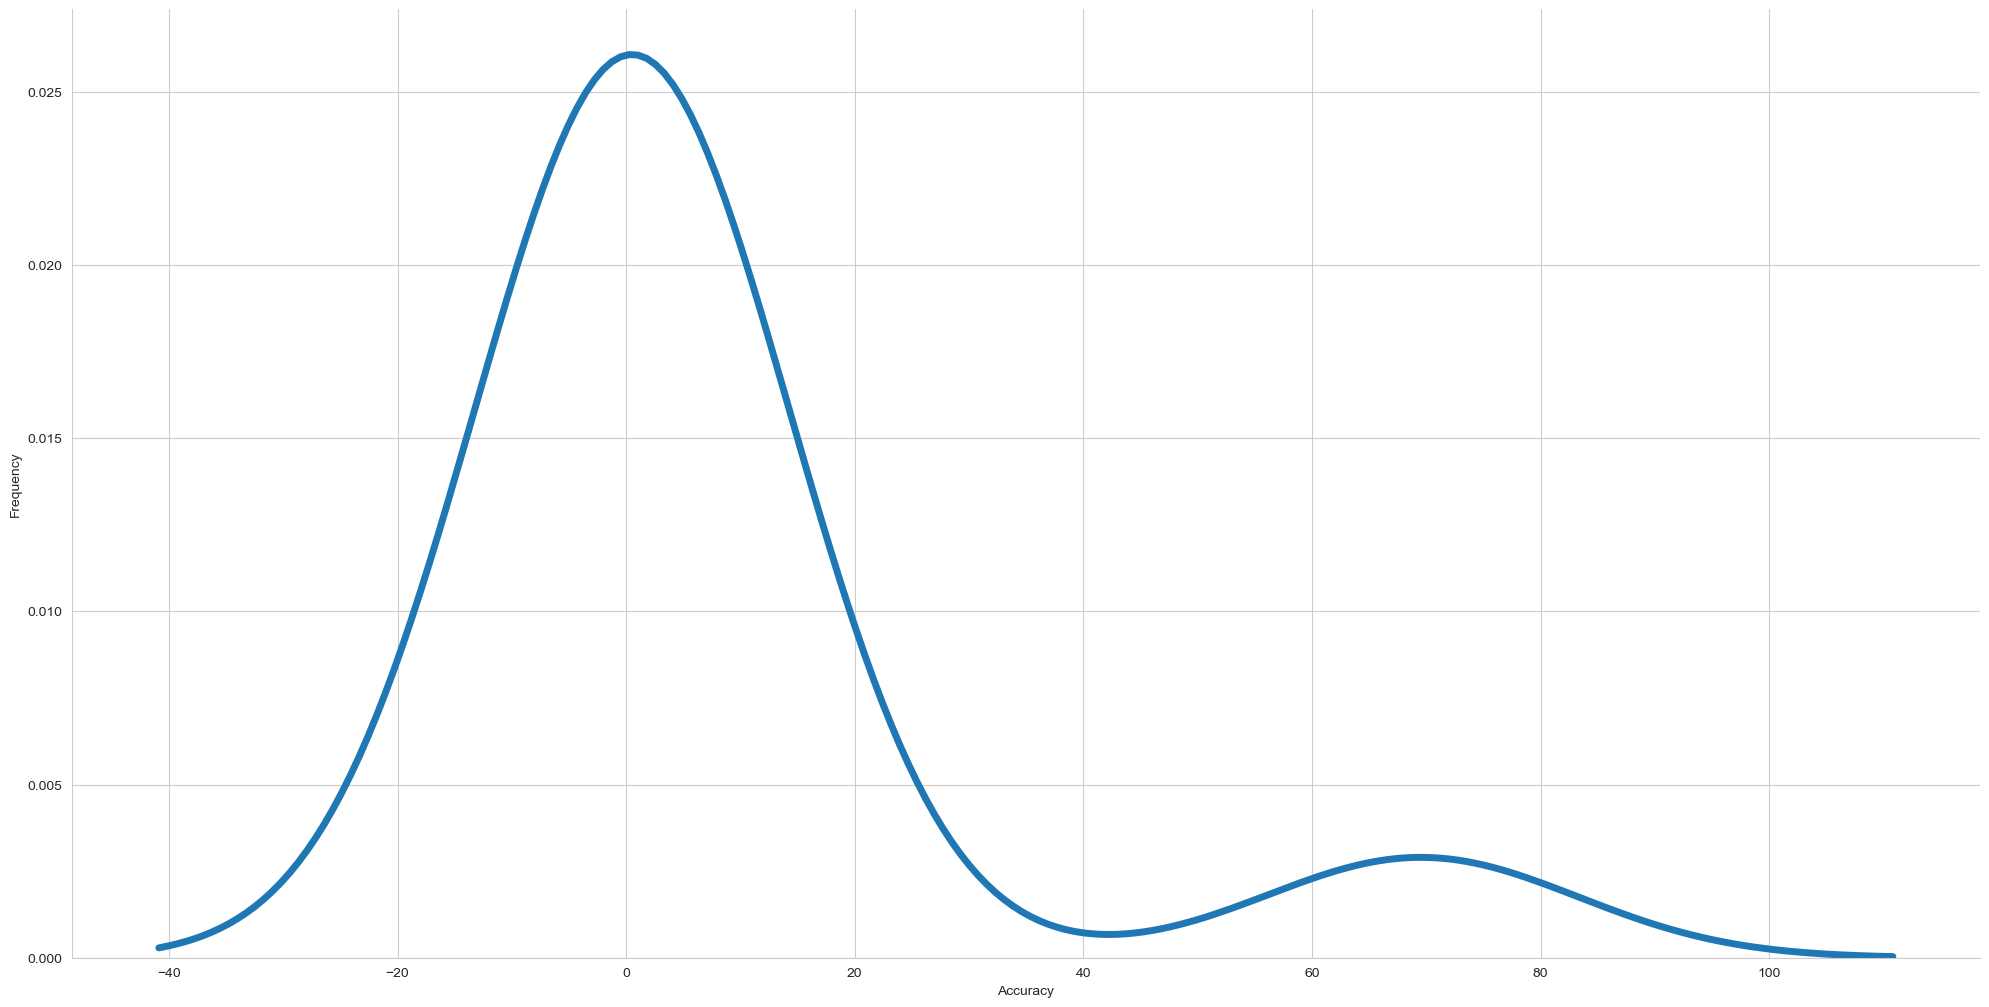

client_ 2  loss:  [0.03972216 0.02067855 0.01909248 0.02059607 0.02184644 0.02210405
 0.0240159  0.02484704 0.02478325 0.02511534] freq:  [18259 18259 18259 18259 18259 18259 18259 18259 18259 18259] acc [0.99611151 0.99989045 1.         1.         1.         0.99994522
 0.99994522 0.99989045 0.99989045 0.99994522]


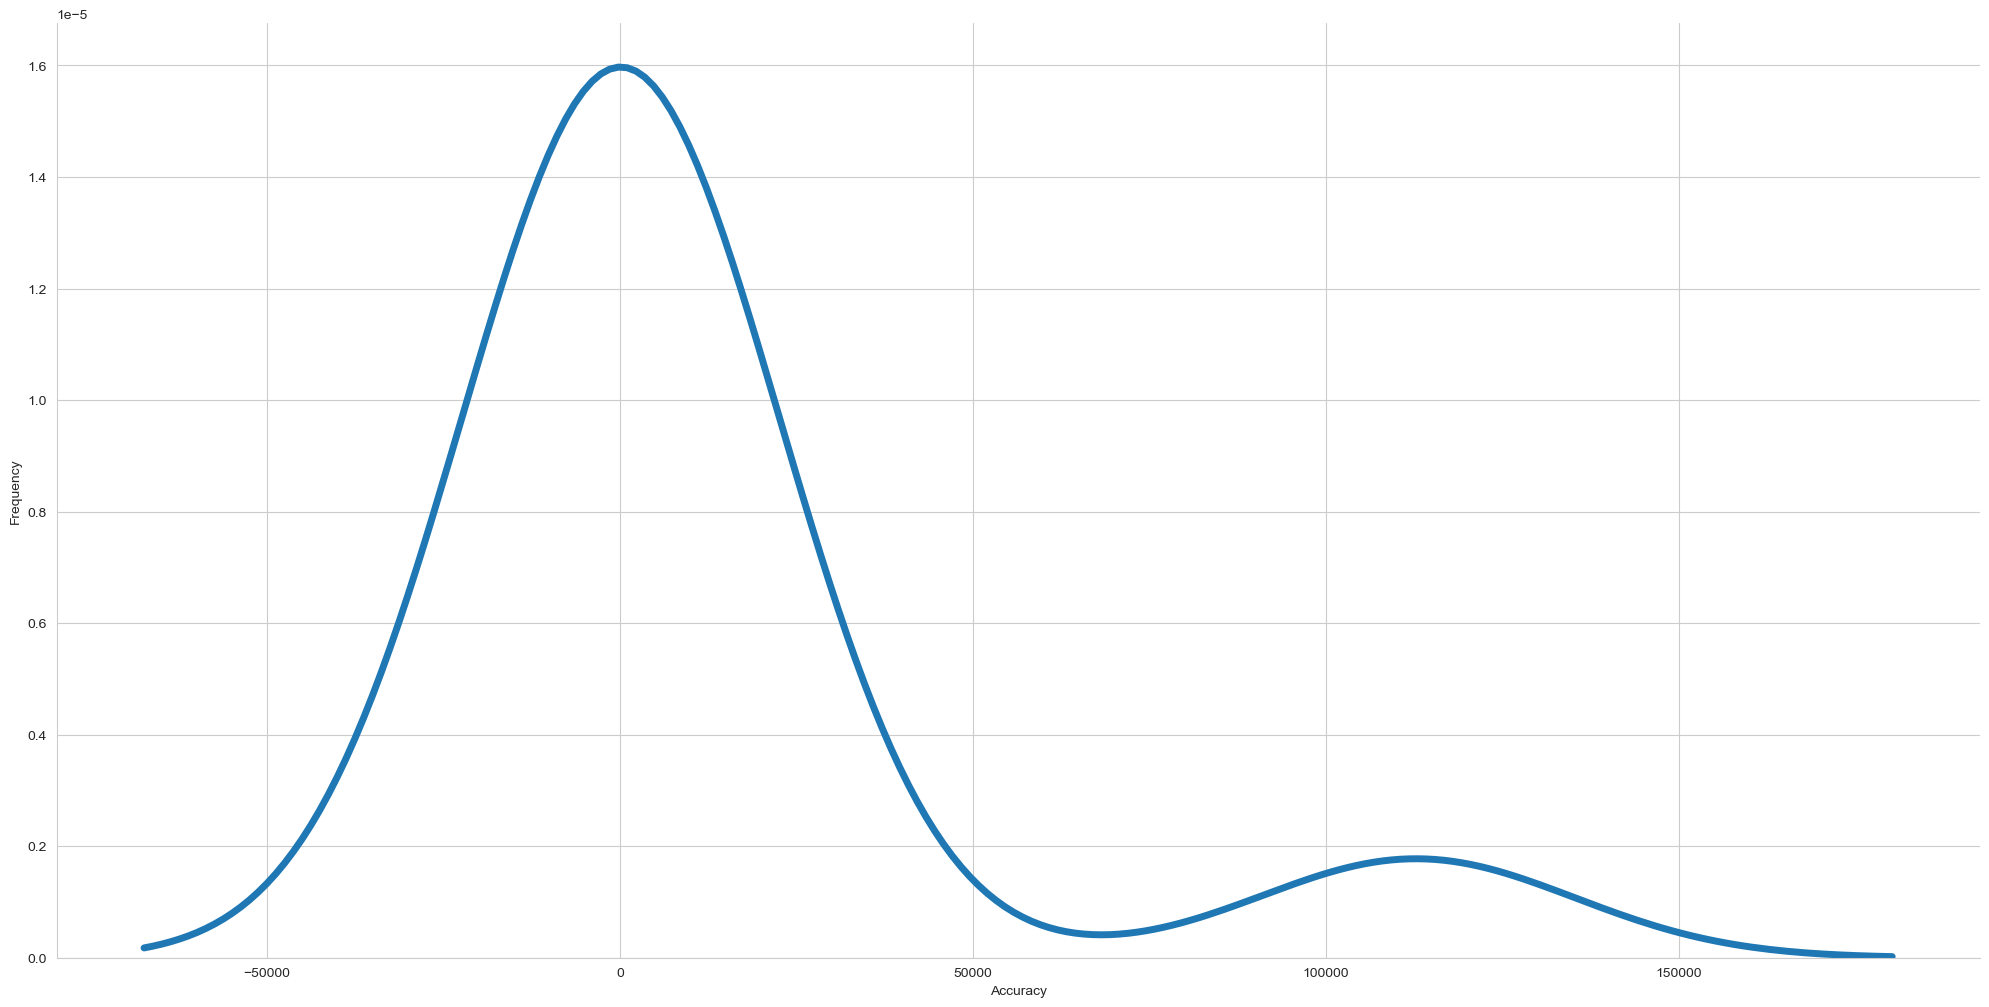

client_ 3  loss:  [0.10719391 0.02389912 0.0262641  0.02447494 0.02615622 0.02859946
 0.0283988  0.02978892 0.03104771 0.03117665] freq:  [11484 11484 11484 11484 11484 11484 11484 11484 11484 11484] acc [0.98885405 0.99965167 0.99982584 0.99991292 0.99991292 0.99991292
 0.99982584 0.99982584 0.99973875 0.99973875]


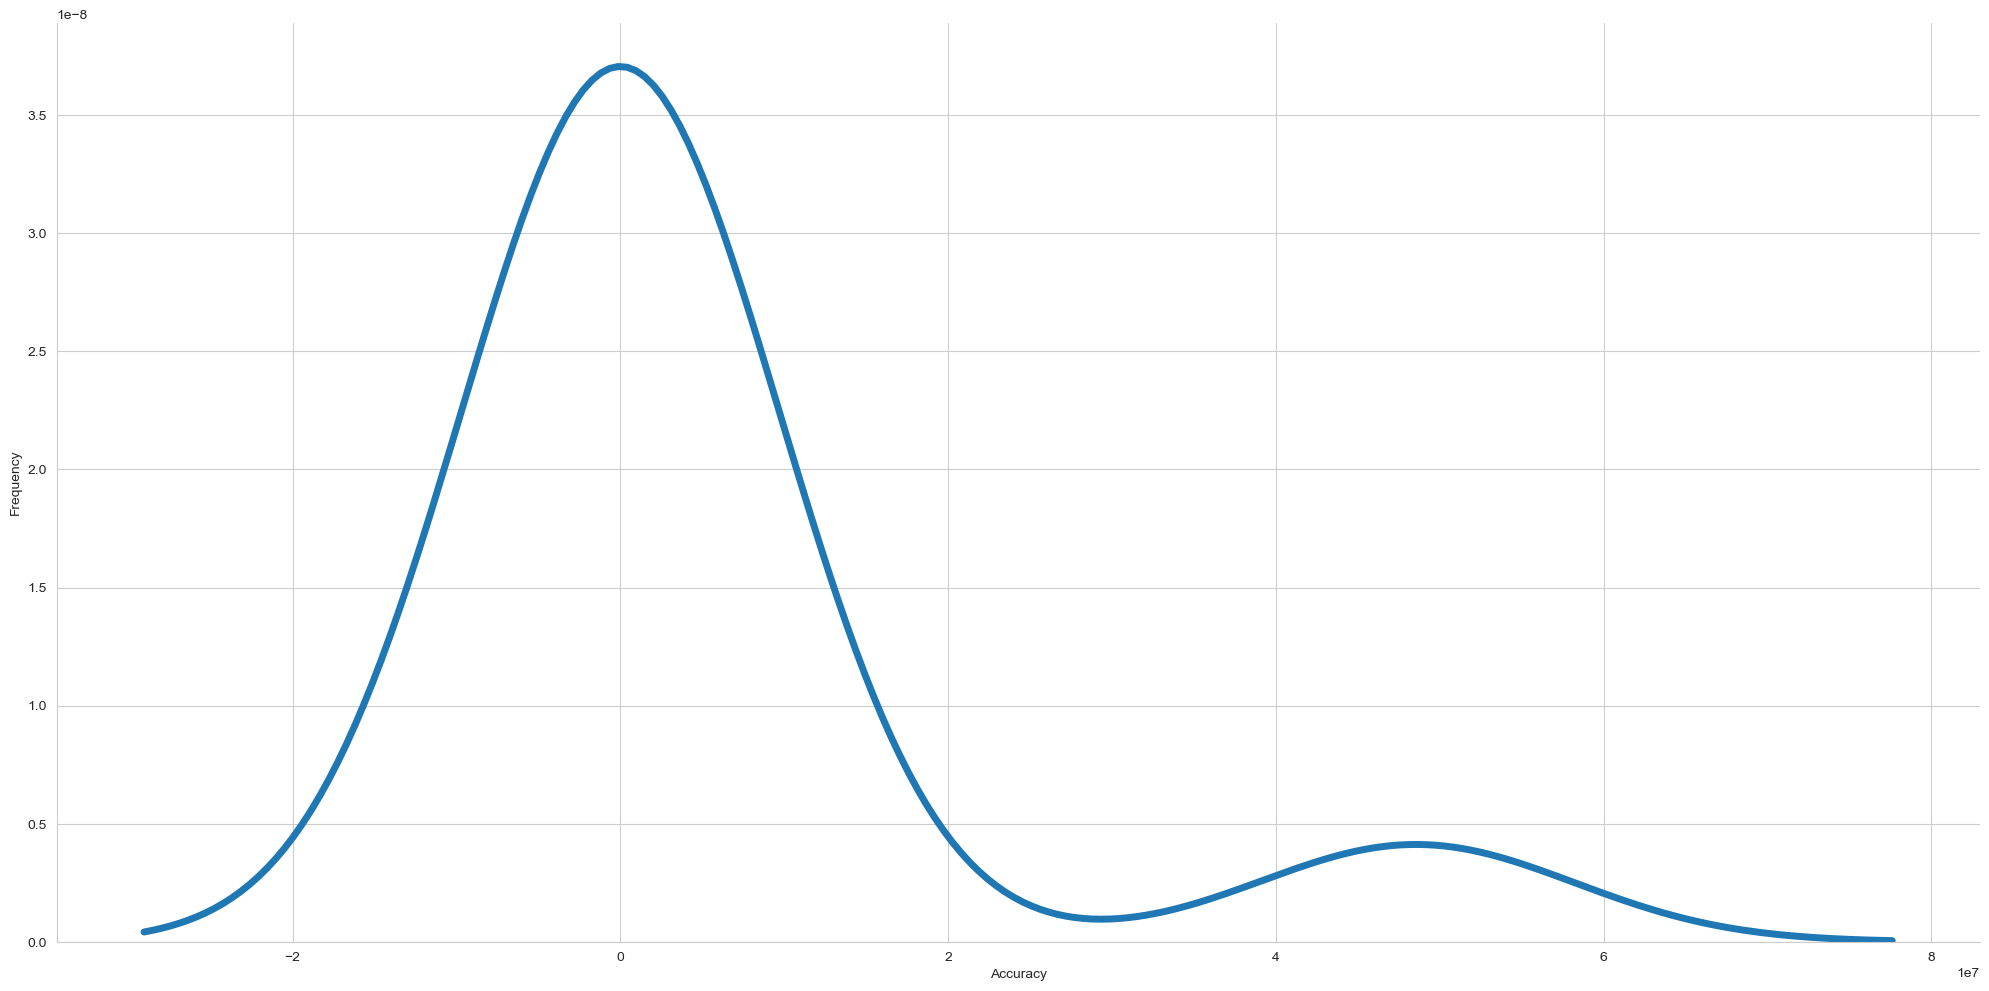

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 

# 4 clients---> gender, income
# pdfs.clear()
pdfs = []
for i in list(client_accuracy.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i], "acc", client_accuracy[i])
    
#     mean, std = stats.norm.fit(client_loss[i])
#     pdf =  stats.norm.pdf(client_loss[i], mean, std)

#     mean, std = stats.norm.fit(client_accuracy[i])
#     pdf = stats.norm.pdf(client_accuracy[i],mean, std )
    
#     mean, std  = stats.norm.fit(client_frequency[i])
#     pdf = stats.norm.pdf(client_frequency[i], mean, std )
    
    
#     df_mean = np.mean(client_loss[i])
#     df_std = np.std(client_loss[i])
#     pdf = stats.norm.pdf(client_loss[i], df_mean, df_std)
#     print(pdf)
#     norm
#     df_mean = np.mean(client_frequency[i])
#     df_std = np.std(client_frequency[i])
#     pdf = stats.norm.pdf(client_frequency[i], df_mean, df_std)
#     print(pdf)
    
#     df_mean = np.mean(client_accuracy[i])
#     df_std = np.std(client_accuracy[i])
#     pdf = stats.norm.pdf(client_accuracy[i], df_mean, df_std)
    
#     lognorm
#     shape, loc, scale = stats.lognorm.fit(client_loss[i])
#     pdf = stats.lognorm.pdf(client_loss[i], shape, loc, scale)

#     shape, loc, scale = stats.lognorm.fit(client_accuracy[i])
#     pdf = stats.lognorm.pdf(client_accuracy[i], shape, loc, scale)
    
#     shape, loc, scale = stats.lognorm.fit(client_frequency[i])
#     pdf = stats.lognorm.pdf(client_frequency[i], shape, loc, scale)
    
#     beta
#     beta_params = stats.beta.fit(client_loss[i])
#     pdf = stats.beta.pdf(client_loss[i], beta_params[0], beta_params[1], beta_params[2], beta_params[3])

#     beta_params = stats.beta.fit(client_accuracy[i])
#     pdf = stats.beta.pdf(client_accuracy[i], beta_params[0], beta_params[1], beta_params[2], beta_params[3])

#     beta_params = stats.beta.fit(client_frequency[i])
#     pdf = stats.beta.pdf(client_frequency[i], beta_params[0], beta_params[1], beta_params[2], beta_params[3])

#     burr
#     burr_params = stats.burr.fit(client_loss[i])
#     pdf = stats.burr.pdf(client_loss[i], burr_params[0], burr_params[1], burr_params[2], burr_params[3])

    
#  gamma
    shape, loc, scale = stats.gamma.fit(client_loss[i])
    pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)
    
    pdfs.append(pdf)
    sns.set_style("whitegrid")

    ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
                linewidth = 5 )
#     ax.fig.suptitle('Original distribution', size = 20)
    plt.ylabel("Frequency")
#     plt.xlabel("Loss")
    plt.xlabel("Accuracy")
    
    plt.show()

In [87]:
for i in list(client_accuracy.keys()):
    print("client_",i, "\nloss: ", client_loss[i],"\nfreq: ", client_frequency[i], "\nacc", client_accuracy[i])

client_ 0 
loss:  [0.04675943 0.22334448 0.3253662  0.3327828  0.32753864 0.30964363
 0.30064547 0.2881389  0.30844659 0.29107651] 
freq:  [7895 7895 7895 7895 7895 7895 7895 7895 7895 7895] 
acc [0.99366689 0.91247624 0.87321091 0.86865103 0.87473083 0.8781507
 0.88081062 0.88777709 0.87941736 0.88448387]
client_ 1 
loss:  [0.44730943 1.00544584 1.24900603 1.09015918 1.2009567  1.20884359
 1.11642206 1.12442636 1.07541847 1.10691833] 
freq:  [1435 1435 1435 1435 1435 1435 1435 1435 1435 1435] 
acc [0.89128917 0.49756098 0.37770036 0.50522649 0.44808361 0.43135887
 0.47804877 0.47456446 0.50662023 0.48989546]
client_ 2 
loss:  [0.03972216 0.02067855 0.01909248 0.02059607 0.02184644 0.02210405
 0.0240159  0.02484704 0.02478325 0.02511534] 
freq:  [18259 18259 18259 18259 18259 18259 18259 18259 18259 18259] 
acc [0.99611151 0.99989045 1.         1.         1.         0.99994522
 0.99994522 0.99989045 0.99989045 0.99994522]
client_ 3 
loss:  [0.10719391 0.02389912 0.0262641  0.02447494 0

In [86]:
print("_GAMMA_")

pdfs_loss_gamma = []
pdfs_acc_gamma = []
pdfs_freq_gamma = []
for i in list(client_accuracy.keys()):
#     print("client_",i, "\nloss: ", client_loss[i],"\nfreq: ", client_frequency[i], "\nacc", client_accuracy[i])

    shape, loc, scale = stats.gamma.fit(client_loss[i])
    pdf_loss_gamma =  stats.gamma.pdf(client_loss[i], shape, loc, scale)
    pdfs_loss_gamma.append(pdf_loss_gamma)

    shape, loc, scale= stats.gamma.fit(client_accuracy[i])
    pdf_acc_gamma = stats.gamma.pdf(client_accuracy[i],shape, loc, scale)
    pdfs_acc_gamma.append(pdf_acc_gamma)

#     shape, loc, scale  = stats.gamma.fit(client_frequency[i])
#     pdf_freq_gamma = stats.gamma.pdf(client_frequency[i],shape, loc, scale )
#     pdfs_freq_gamma.append(pdf_freq_gamma)


print("ACCURACY")
for i in range(len(pdfs_acc_gamma)):
    for j in range(i+1,len(pdfs_acc_gamma)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc_gamma[i], pdfs_acc_gamma[j]))


shape, loc, scale = stats.gamma.fit(global_acc_list)
pdf_global_acc_gamma =  stats.gamma.pdf(global_acc_list, shape, loc, scale)

for i in range(len(pdfs_acc_gamma)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc_gamma[i], pdf_global_acc_gamma))

print("LOSS")
for i in range(len(pdfs_loss_gamma)):
    for j in range(i+1,len(pdfs_loss_gamma)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss_gamma[i], pdfs_loss_gamma[j]))


shape, loc, scale = stats.gamma.fit(global_loss_list)
pdf_global_loss_gamma =  stats.gamma.pdf(global_loss_list, shape, loc, scale)

for i in range(len(pdfs_loss_gamma)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss_gamma[i], pdf_global_loss_gamma))

# print("FREQUENCY")
# for i in range(len(pdfs_freq_gamma)):
#     for j in range(i+1,len(pdfs_freq_gamma)):
#         print(i," and ", j , stats.wasserstein_distance(pdfs_freq_gamma[i], pdfs_freq_gamma[j]))


# shape, loc, scale = stats.gamma.fit(global_freq_list)
# pdf_global_freq_gamma =  stats.gamma.pdf(global_freq_list,shape, loc, scale)

# for i in range(len(pdfs_freq_gamma)):
#     print(i," and global: " , stats.wasserstein_distance(pdfs_freq_gamma[i], pdf_global_freq_gamma))

_GAMMA_
ACCURACY
0  and  1 5052963785.6386385
0  and  2 110213288418.12776
0  and  3 107785490295.07877
1  and  2 105160324655.85822
1  and  3 102732526518.81839
2  and  3 2427798137.039818
0  and global:  2170527.9642331777
1  and global:  5050793767.680869
2  and global:  110211118394.07294
3  and global:  107783320275.70663
LOSS
0  and  1 9.308714649162779
0  and  2 11341.601002166437
0  and  3 4854633.798060776
1  and  2 11337.843632987884
1  and  3 4854630.040691596
2  and  3 4843350.173976158
0  and global:  6.269837293033752
1  and global:  13.414506742209406
2  and global:  11335.51733712475
3  and global:  4854628.48416662


In [84]:
print("_NORM_")

pdfs_loss_norm = []
pdfs_acc_norm = []
pdfs_freq_norm = []
for i in list(client_accuracy.keys()):
#     print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i], "acc", client_accuracy[i])
    
    mean, std = stats.norm.fit(client_loss[i])
    pdf_loss_norm =  stats.norm.pdf(client_loss[i], mean, std)
    pdfs_loss_norm.append(pdf_loss_norm)

    mean, std = stats.norm.fit(client_accuracy[i])
    pdf_acc_norm = stats.norm.pdf(client_accuracy[i],mean, std )
    pdfs_acc_norm.append(pdf_acc_norm)
    
    mean, std  = stats.norm.fit(client_frequency[i])
    pdf_freq_norm = stats.norm.pdf(client_frequency[i], mean, std )
    pdfs_freq_norm.append(pdf_freq_norm)
    
    
print("ACCURACY")
for i in range(len(pdfs_acc_norm)):
    for j in range(i+1,len(pdfs_acc_norm)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc_norm[i], pdfs_acc_norm[j]))
        
        
mean, std = stats.norm.fit(global_acc_list)
pdf_global_acc_norm =  stats.norm.pdf(global_acc_list, mean, std)

for i in range(len(pdfs_acc_norm)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc_norm[i], pdf_global_acc_norm))
    
print("LOSS")
for i in range(len(pdfs_loss_norm)):
    for j in range(i+1,len(pdfs_loss_norm)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss_norm[i], pdfs_loss_norm[j]))
        
        
mean, std = stats.norm.fit(global_loss_list)
pdf_global_loss_norm =  stats.norm.pdf(global_loss_list, mean, std)

for i in range(len(pdfs_loss_norm)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss_norm[i], pdf_global_loss_norm))
    
# print("FREQUENCY")
# for i in range(len(pdfs_freq_norm)):
#     for j in range(i+1,len(pdfs_freq_norm)):
#         print(i," and ", j , stats.wasserstein_distance(pdfs_freq_norm[i], pdfs_freq_norm[j]))
        
        
# mean, std = stats.norm.fit(global_freq_list)
# pdf_global_freq_norm =  stats.norm.pdf(global_freq_list, mean, std)

# for i in range(len(pdfs_freq_norm)):
#     print(i," and global: " , stats.wasserstein_distance(pdfs_freq_norm[i], pdf_global_freq_norm))


_NORM_
ACCURACY
0  and  1 6.675711374677921
0  and  2 286.15857542033956
0  and  3 94.18641588484508
1  and  2 292.8342867950175
1  and  3 100.86212725952299
2  and  3 191.97215953549448
0  and global:  1091.4961367516255
1  and global:  1098.1718481263035
2  and global:  805.337561331286
3  and global:  997.3097208667805
LOSS
0  and  1 2.4057410423621155
0  and  2 54.555577640223106
0  and  3 10.220130044593963
1  and  2 56.96131868258523
1  and  3 12.62587108695608
2  and  3 44.33544759562915
0  and global:  6.002736887598183
1  and global:  8.408477929960299
2  and global:  49.369079300209755
3  and global:  5.281169731086335


In [83]:
print("_LOGNORM_")

pdfs_loss = []
pdfs_acc = []
pdfs_freq = []
for i in list(client_accuracy.keys()):
#     print("client_",i, "\nloss: ", client_loss[i],"\nfreq: ", client_frequency[i], "\nacc", client_accuracy[i])

    shape, loc, scale = stats.lognorm.fit(client_loss[i])
    pdf_loss =  stats.lognorm.pdf(client_loss[i], shape, loc, scale)
    pdfs_loss.append(pdf_loss)

    shape, loc, scale= stats.lognorm.fit(client_accuracy[i])
    pdf_acc = stats.lognorm.pdf(client_accuracy[i],shape, loc, scale)
    pdfs_acc.append(pdf_acc)

#     shape, loc, scale  = stats.lognorm.fit(client_frequency[i])
#     pdf_freq = stats.lognorm.pdf(client_frequency[i],shape, loc, scale )
#     pdfs_freq.append(pdf_freq)


print("ACCURACY")
for i in range(len(pdfs_acc)):
    for j in range(i+1,len(pdfs_acc)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc[i], pdfs_acc[j]))


shape, loc, scale = stats.lognorm.fit(global_acc_list)
pdf_global_acc =  stats.lognorm.pdf(global_acc_list, shape, loc, scale)

for i in range(len(pdfs_acc)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc[i], pdf_global_acc))

print("LOSS")
for i in range(len(pdfs_loss)):
    for j in range(i+1,len(pdfs_loss)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss[i], pdfs_loss[j]))


shape, loc, scale = stats.lognorm.fit(global_loss_list)
pdf_global_loss =  stats.lognorm.pdf(global_loss_list, shape, loc, scale)

for i in range(len(pdfs_loss)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss[i], pdf_global_loss))

# print("FREQUENCY")
# for i in range(len(pdfs_freq)):
#     for j in range(i+1,len(pdfs_freq)):
#         print(i," and ", j , stats.wasserstein_distance(pdfs_freq[i], pdfs_freq[j]))


# shape, loc, scale = stats.lognorm.fit(global_freq_list)
# pdf_global_freq =  stats.lognorm.pdf(global_freq_list,shape, loc, scale)

# for i in range(len(pdfs_freq)):
#     print(i," and global: " , stats.wasserstein_distance(pdfs_freq[i], pdf_global_freq))

_LOGNORM_
ACCURACY
0  and  1 20.848571350665924
0  and  2 68.43472489365098
0  and  3 78.13086556288947
1  and  2 89.2832962443169
1  and  3 98.97943691355539
2  and  3 84.68423389603093
0  and global:  1078.2990797532764
1  and global:  1099.1476511039423
2  and global:  1015.7192759065204
3  and global:  1000.1682141903868
LOSS
0  and  1 2.396580615537854
0  and  2 88.29790770059965
0  and  3 79.39303651314505
1  and  2 90.69448831613751
1  and  3 81.7896171286829
2  and  3 32.77755483496762
0  and global:  6.029857038491165
1  and global:  8.426437654029018
2  and global:  82.74258355514098
3  and global:  74.39622381424006


In [88]:
print("_BETA_")

pdfs_loss = []
pdfs_acc = []
pdfs_freq = []
for i in list(client_accuracy.keys()):

    beta_params = stats.beta.fit(client_loss[i])
    pdf_loss =  stats.beta.pdf(client_loss[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_loss.append(pdf_loss)

    beta_params = stats.beta.fit(client_accuracy[i])
    pdf_acc = stats.beta.pdf(client_accuracy[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_acc.append(pdf_acc)

#     beta_params  = stats.beta.fit(client_frequency[i])
#     pdf_freq = stats.beta.pdf(client_frequency[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
#     pdfs_freq.append(pdf_freq)


print("ACCURACY")
for i in range(len(pdfs_acc)):
    for j in range(i+1,len(pdfs_acc)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc[i], pdfs_acc[j]))


beta_params = stats.beta.fit(global_acc_list)
pdf_global_acc =  stats.beta.pdf(global_acc_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_acc)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc[i], pdf_global_acc))

print("LOSS")
for i in range(len(pdfs_loss)):
    for j in range(i+1,len(pdfs_loss)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss[i], pdfs_loss[j]))


beta_params = stats.beta.fit(global_loss_list)
pdf_global_loss =  stats.beta.pdf(global_loss_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_loss)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss[i], pdf_global_loss))

# print("FREQUENCY")
# for i in range(len(pdfs_freq)):
#     for j in range(i+1,len(pdfs_freq)):
#         print(i," and ", j , stats.wasserstein_distance(pdfs_freq[i], pdfs_freq[j]))


# beta_params = stats.beta.fit(global_freq_list)
# pdf_global_freq =  stats.beta.pdf(global_freq_list,beta_params[0], beta_params[1], beta_params[2], beta_params[3])

# for i in range(len(pdfs_freq)):
#     print(i," and global: " , stats.wasserstein_distance(pdfs_freq[i], pdf_global_freq))

_BETA_


C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


ACCURACY
0  and  1 1521748664975.6758
0  and  2 210969340692530.25
0  and  3 30110798953388.42
1  and  2 212491089357505.84
1  and  3 31632547618362.84
2  and  3 180858541739143.1
0  and global:  308744075720725.44
1  and global:  310265824385701.06
2  and global:  385995910701328.75
3  and global:  325709730121620.6
LOSS
0  and  1 2314866766485.9023
0  and  2 10624594890126.223
0  and  3 4839861950005.761
1  and  2 12939461656612.125
1  and  3 7154728716486.841
2  and  3 5784732940125.554
0  and global:  4391291160872.917
1  and global:  2076424394391.9973
2  and global:  15015886050987.99
3  and global:  9231153110878.678


In [90]:
print("_BURR_")

pdfs_loss = []
pdfs_acc = []
pdfs_freq = []
for i in list(client_accuracy.keys()):

    params = stats.burr.fit(client_loss[i])
    pdf_loss =  stats.burr.pdf(client_loss[i],params[0], params[1], params[2], params[3])
    pdfs_loss.append(pdf_loss)

    beta_params = stats.burr.fit(client_accuracy[i])
    pdf_acc = stats.burr.pdf(client_accuracy[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_acc.append(pdf_acc)

#     beta_params  = stats.burr.fit(client_frequency[i])
#     pdf_freq = stats.burr.pdf(client_frequency[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
#     pdfs_freq.append(pdf_freq)


print("ACCURACY")
for i in range(len(pdfs_acc)):
    for j in range(i+1,len(pdfs_acc)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc[i], pdfs_acc[j]))


beta_params = stats.burr.fit(global_acc_list)
pdf_global_acc =  stats.burr.pdf(global_acc_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_acc)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc[i], pdf_global_acc))

print("LOSS")
for i in range(len(pdfs_loss)):
    for j in range(i+1,len(pdfs_loss)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss[i], pdfs_loss[j]))


beta_params = stats.burr.fit(global_loss_list)
pdf_global_loss =  stats.burr.pdf(global_loss_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_loss)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss[i], pdf_global_loss))

# print("FREQUENCY")
# for i in range(len(pdfs_freq)):
#     for j in range(i+1,len(pdfs_freq)):
#         print(i," and ", j , stats.wasserstein_distance(pdfs_freq[i], pdfs_freq[j]))


# beta_params = stats.burr.fit(global_freq_list)
# pdf_global_freq =  stats.burr.pdf(global_freq_list,beta_params[0], beta_params[1], beta_params[2], beta_params[3])

# for i in range(len(pdfs_freq)):
#     print(i," and global: " , stats.wasserstein_distance(pdfs_freq[i], pdf_global_freq))

_BURR_
ACCURACY
0  and  1 12.557451473326129
0  and  2 73.81034375812625
0  and  3 58.98077024145226
1  and  2 86.36779523145239
1  and  3 71.5382217147784
2  and  3 14.82957351667399
0  and global:  37.68286544026416
1  and global:  50.24031691359029
2  and global:  36.12747831786209
3  and global:  30.816360768026254
LOSS
0  and  1 5.9800054838741215
0  and  2 85.11174054509708
0  and  3 14009025718706.021
1  and  2 91.09174602897119
1  and  3 14009025718712.0
2  and  3 14009025718739.184
0  and global:  2.2096049476649746
1  and global:  7.564232292959562
2  and global:  83.77601115000714
3  and global:  14009025718705.12


In [ ]:
for i in list(client_loss.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
    print("client_",i, "loss: ", client_loss[i])

In [91]:
for i in list(client_loss.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
    print("client_",i, "freq: ", client_frequency[i])

client_ 0 freq:  [7895 7895 7895 7895 7895 7895 7895 7895 7895 7895]
client_ 1 freq:  [1435 1435 1435 1435 1435 1435 1435 1435 1435 1435]
client_ 2 freq:  [18259 18259 18259 18259 18259 18259 18259 18259 18259 18259]
client_ 3 freq:  [11484 11484 11484 11484 11484 11484 11484 11484 11484 11484]


In [ ]:
for i in range(len(pdfs)):
    for j in range(i+1,len(pdfs)):
        print(i," and ", j , stats.wasserstein_distance(pdfs[i], pdfs[j]))

In [ ]:
# # gamma
shape, loc, scale = stats.gamma.fit(global_freq_list)
pdf_global = stats.gamma.pdf(global_freq_list, shape, loc=loc, scale=scale)

# df_mean = np.mean(global_loss_list)
# df_std = np.std(global_loss_list)
# pdf_global = stats.norm.pdf(global_loss_list, df_mean, df_std)

# mean, std = stats.norm.fit(global_freq_list)
# pdf_global =  stats.norm.pdf(global_freq_list, mean, std)

# lognorm
# shape, loc, scale = stats.lognorm.fit(global_loss_list)
# pdf_global = stats.lognorm.pdf(global_loss_list, shape, loc, scale)

# global_acc_list
# global_freq_list

# burr
# burr_params = stats.beta.fit(global_freq_list)
# pdf_global = stats.beta.pdf(global_freq_list, burr_params[0], burr_params[1], burr_params[2], burr_params[3])

for i in range(len(pdfs)):
    print(i," and global: " , stats.wasserstein_distance(pdfs[i], pdf_global))

In [ ]:
!pip install fitter

In [ ]:
# from fitter import Fitter, get_common_distributions, get_distributions

# for i in list(client_loss.keys()):
#     height = client_loss[i]

#     f = Fitter(height,
#                distributions=['gamma',
#                               'lognorm',
#                               "beta",
#                               "burr",
#                               "norm"])
#     f.fit()
#     f.summary()

#     sns.set_style('white')
#     sns.set_context("paper", font_scale = 2)
#     sns.displot(data=dataset, x="Height", kind="hist", bins = 100, aspect = 1.5)

In [ ]:
# 8 clients---> gender, race, income
pdfs = []
for i in list(client_loss.keys()):
    if(i== len(list(client_loss.keys()))-1):
        continue
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])

#     shape, loc, scale = stats.gamma.fit(client_loss[i])
    
#     # Printing the estimated parameters
#     print("Shape:", shape)
#     print("Location:", loc)
#     print("Scale:", scale)
#     pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)
    
    
    df_mean = np.mean(client_loss[i])
    df_std = np.std(client_loss[i])
    pdf = stats.norm.pdf(client_loss[i], df_mean, df_std)
    pdfs.append(pdf)
    sns.set_style("whitegrid")

    ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
                linewidth = 5 )
    ax.fig.suptitle('Original distribution', size = 20)
    plt.ylabel("Frequency")
    plt.xlabel("Loss")
    plt.show()

In [ ]:
for i in range(len(pdfs)):
    for j in range(i+1,len(pdfs)):
        print(i," and ", j , stats.wasserstein_distance(pdfs[i], pdfs[j]))

In [ ]:
shape, loc, scale = stats.gamma.fit(global_loss_list)
pdf_global = stats.gamma.pdf(global_loss_list, shape, loc=loc, scale=scale)

for i in range(len(pdfs)):
    print(i," and global: " , stats.wasserstein_distance(pdfs[i], pdf_global))

In [ ]:
# experiment plotter

# for i in list(client_loss.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
#     print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])
    
# #     df_mean = np.mean(client_loss[i])
# #     df_std = np.std(client_loss[i])
# #     pdf = stats.norm.pdf(client_loss[i], df_mean, df_std)

#     shape, loc, scale = stats.gamma.fit(client_loss[i])
    
#     # Printing the estimated parameters
# #     print("Shape:", shape)
# #     print("Location:", loc)
# #     print("Scale:", scale)
#     pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)

# #     plt.plot(client_loss[i], pdf, "-o", label = i)

# #     client_loss[i] = stats.gamma.rvs(1, size=5000)+5
#     sns.set_style("whitegrid")

#     ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
#                 linewidth = 5 )
#     ax.fig.suptitle('Original distribution', size = 20)
# #     plt.plot(client_loss[i], client_frequency[i], "-o", label = i)
# #     plt.legend()
#     plt.ylabel("Frequency")
#     plt.xlabel("Loss")
#     plt.show()

In [ ]:
score = global_model.evaluate(X_test, y_test, verbose=0)
score

In [ ]:
nn_preds = global_model.predict(X_test)
nn_preds = (nn_preds > 0.5)

nn_precision =precision_score(y_test, nn_preds)
nn_recall = recall_score(y_test, nn_preds)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_f1 = f1_score(y_test, nn_preds)


print("Precision = {}".format(nn_precision))
print("Recall = {}".format(nn_recall))
print("Accuracy = {}".format(nn_accuracy))
print("f1 = {}".format(nn_f1))


In [ ]:
arr = nn_preds > 0.5

unique, counts = np.unique(arr, return_counts=True)

np.asarray((unique, counts)).T

In [ ]:
# pdf for client losses
# x-loss
# y- frequency
# each client has one pdf for all rounds
# using histogram


# drop client
# non iid
# fedavg


# gender dist
# kernel density


# non-iid, loss to accuracy
# 4client